In [1]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

In [2]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='tf')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


好的！我们使用GPT2 generated生成了第一个简短文本。根据上下文生成的单词是合理的，但是模型很快就会开始重复！一般来说，这是语言生成中一个非常普遍的问题，在贪婪和波束搜索中似乎更是如此-请查看Vijayakumar等人，2016和Shao等人，2017。



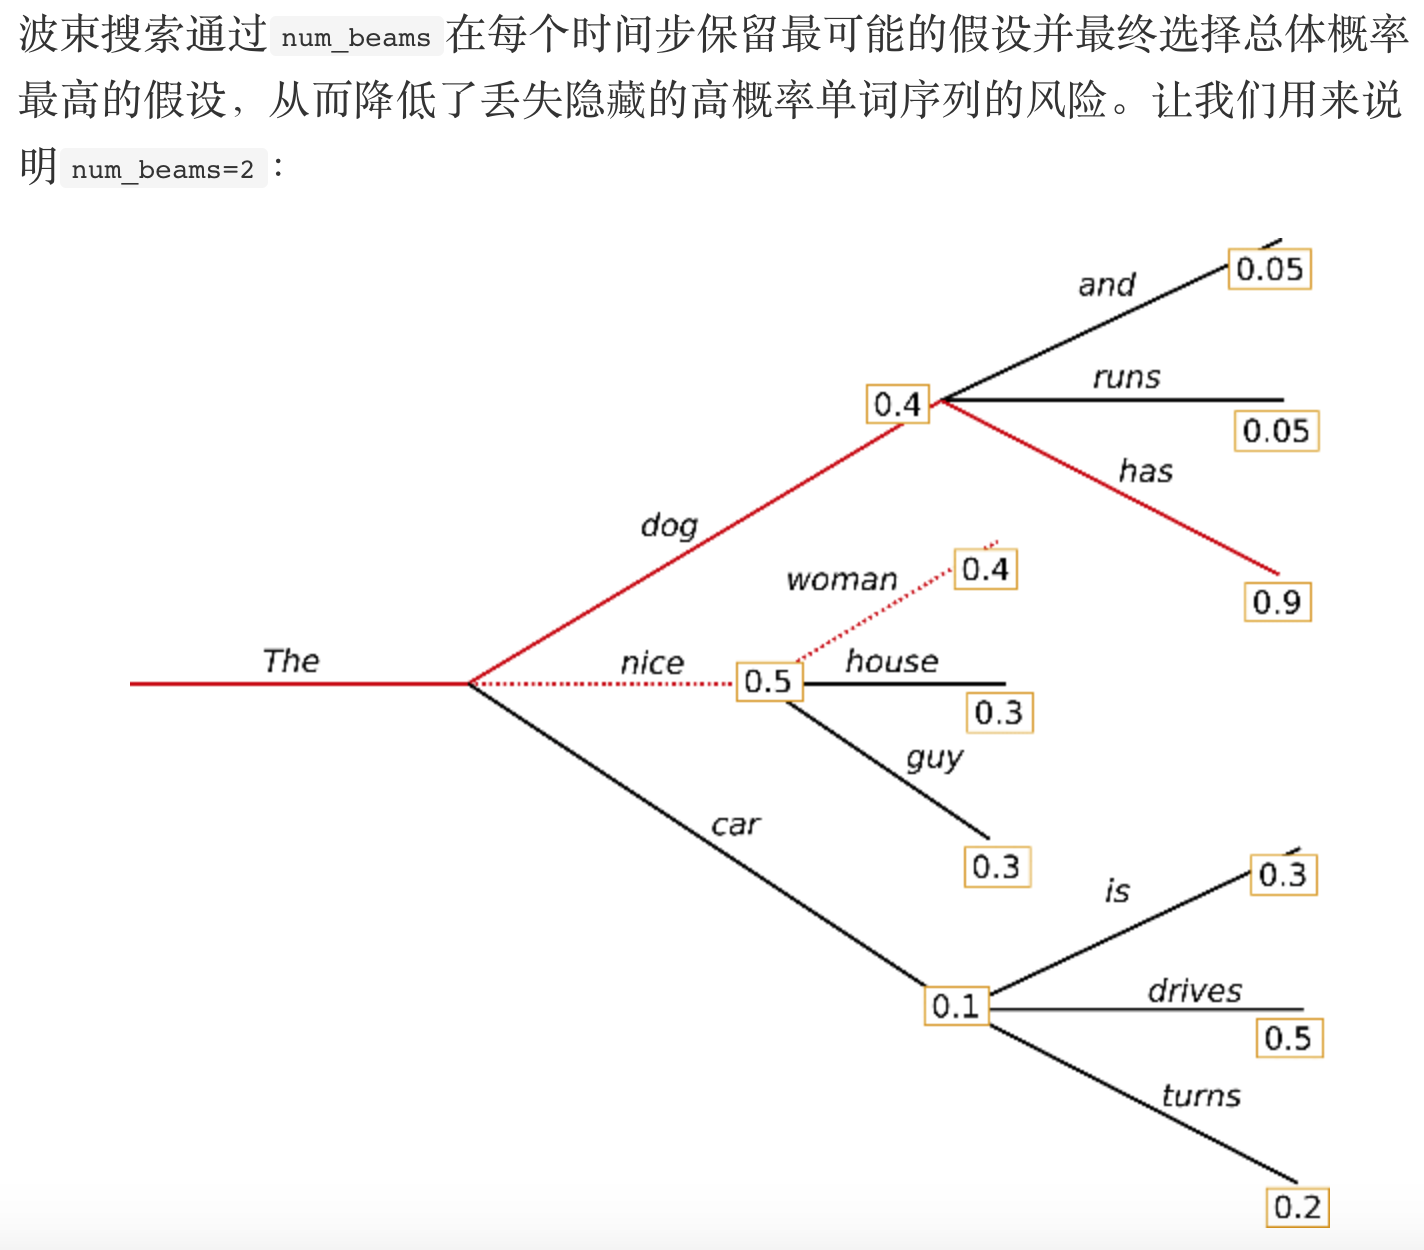

在时间步 1个1个除了最可能的假设\（\ text {“ The”，“ woman”} \），波束搜索还跟踪第二个最可能的假设 \ text {“ The”，“ dog”}“那个”，“狗”。在时间步22，波束搜索发现单词序列 \ text {“ The”，“ dog”，“ has”}“该”，“狗”，“有” 具有\（0.36 \）的概率比 \ text {“ The”，“ nice”，“ woman”}“ The”，“ nice”，“ woman”， 其中有 0.20 。2。太好了，它已经在我们的玩具示例中找到了最可能的单词序列！

波束搜索将始终找到比贪婪搜索具有更高概率的输出序列，但不能保证找到最可能的输出。

In [3]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll


在开放式的一代中，最近提出了两个原因，为什么波束搜索可能不是最佳选择：

* 光束搜索在机器翻译或摘要中或多或少可预测的任务长度上可以很好地完成工作-参见Murray等。（2018）和Yang等。（2018）。但这对于开放式生成而言并非如此，在开放式生成中，所需的输出长度会发生很大变化，例如，对话和故事生成。

* 我们已经看到，波束搜索严重受到重复生成的困扰。这很难用n-gram *-或故事生成中的其他惩罚来控制，因为要在强制“不重复”和相同* n-grams的重复循环之间找到良好的平衡，需要进行很多微调。

* 正如Ari Holtzman等人所述。（2019），高质量的人类语言不会遵循高概率的下一个单词的分布。换句话说，作为人类，我们希望生成的文本使我们感到惊讶，而不是无聊/不可预测。作者通过绘制概率来很好地说明这一点，模型将给出人类文本与波束搜索的作用。

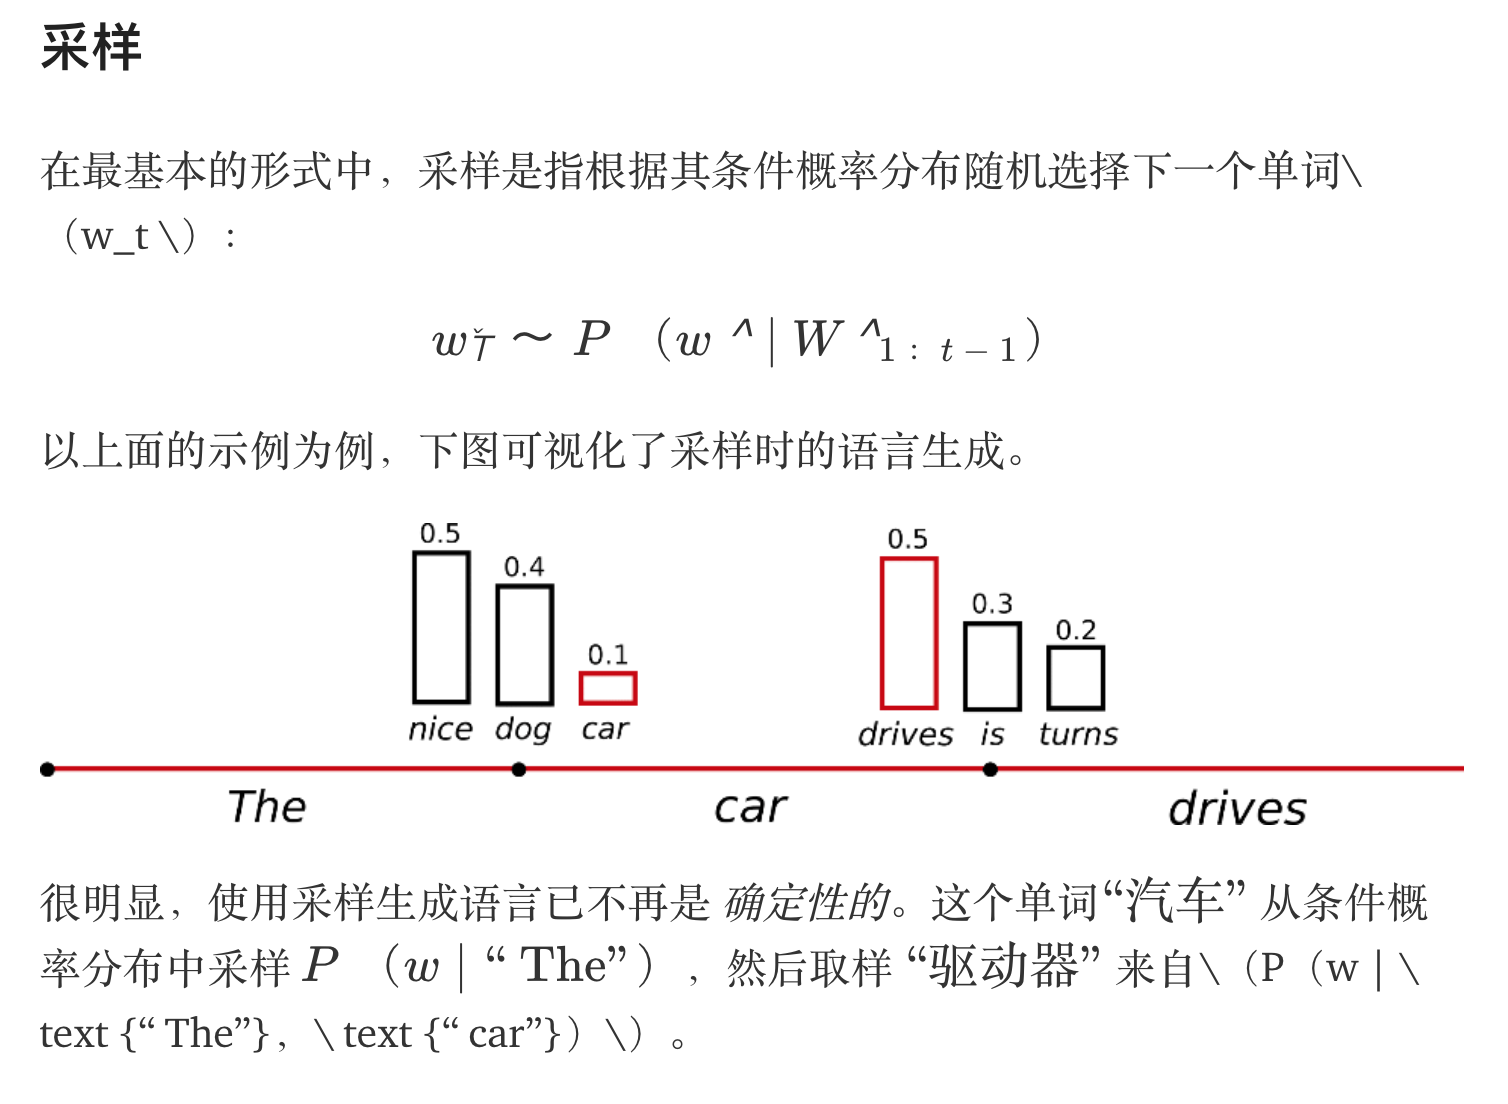

In [4]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog. He just gave me a whole new hand sense."

But it seems that the dogs have learned a lot from teasing at the local batte harness once they take on the outside.

"I take


有趣！文字似乎还不错-但仔细观察时，文字并不太连贯。在3克 新手感和本地蓄电池装填吊带是很奇怪的，不听起来像他们被人写的。在对单词序列进行采样时，这是一个大问题：模型通常会产生不连贯的胡言乱语，比照。 Ari Holtzman等。（2019）。

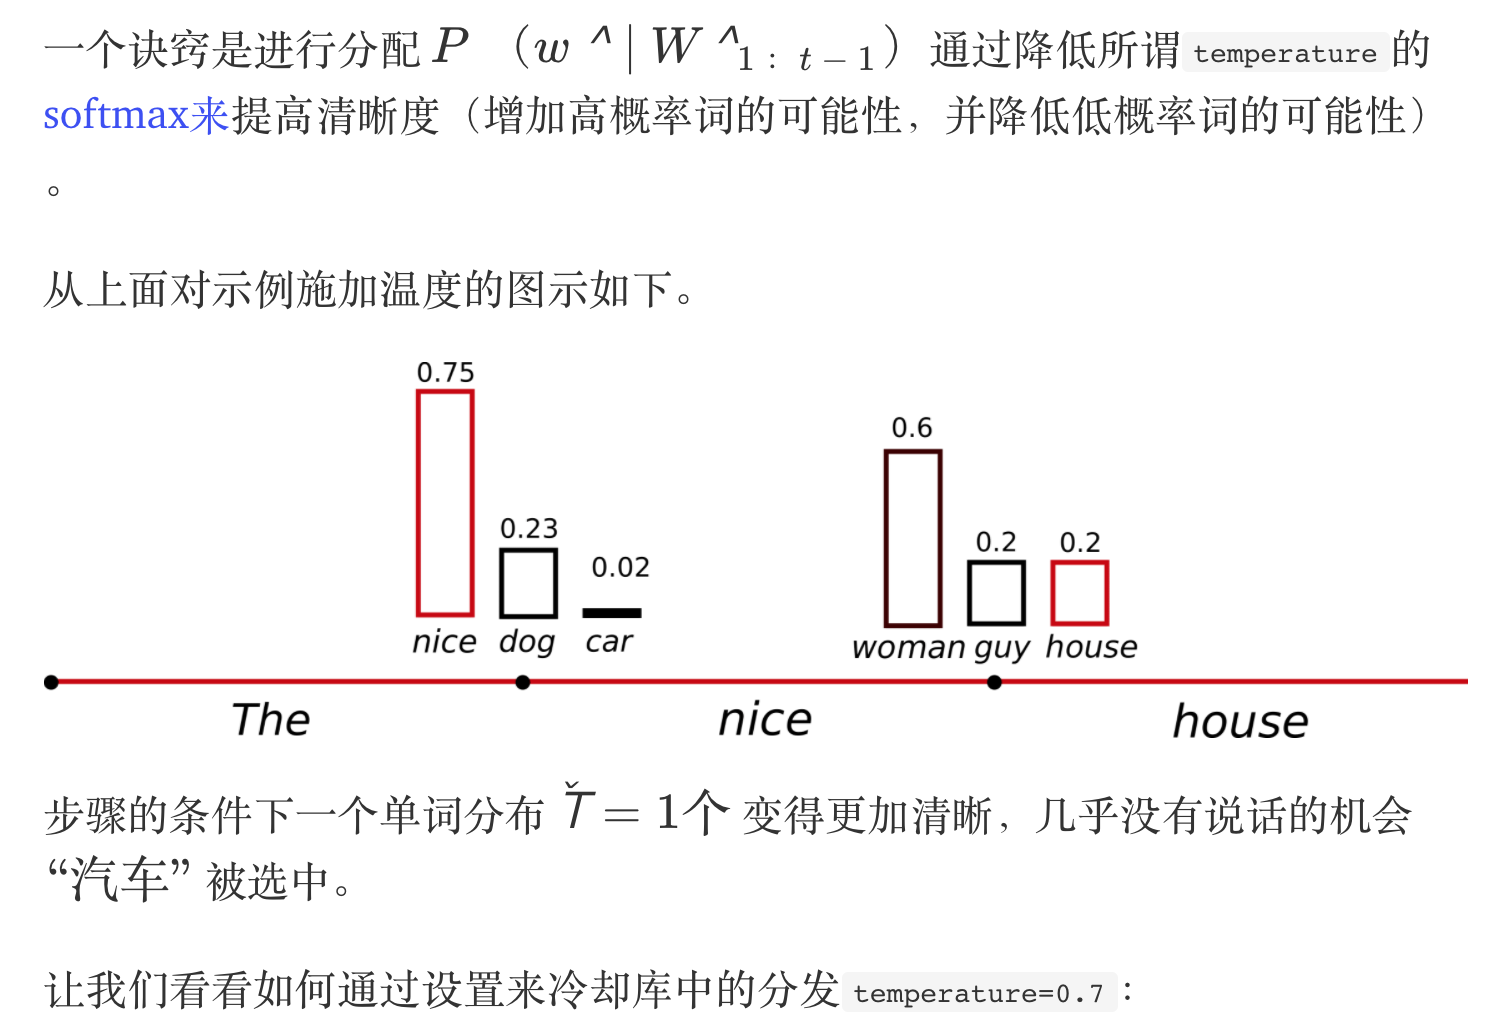

In [5]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# use temperature to decrease the sensitivity to low probability candidates
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0, 
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I don't like to be at home too much. I also find it a bit weird when I'm out shopping. I am always away from my house a lot, but I do have a few friends


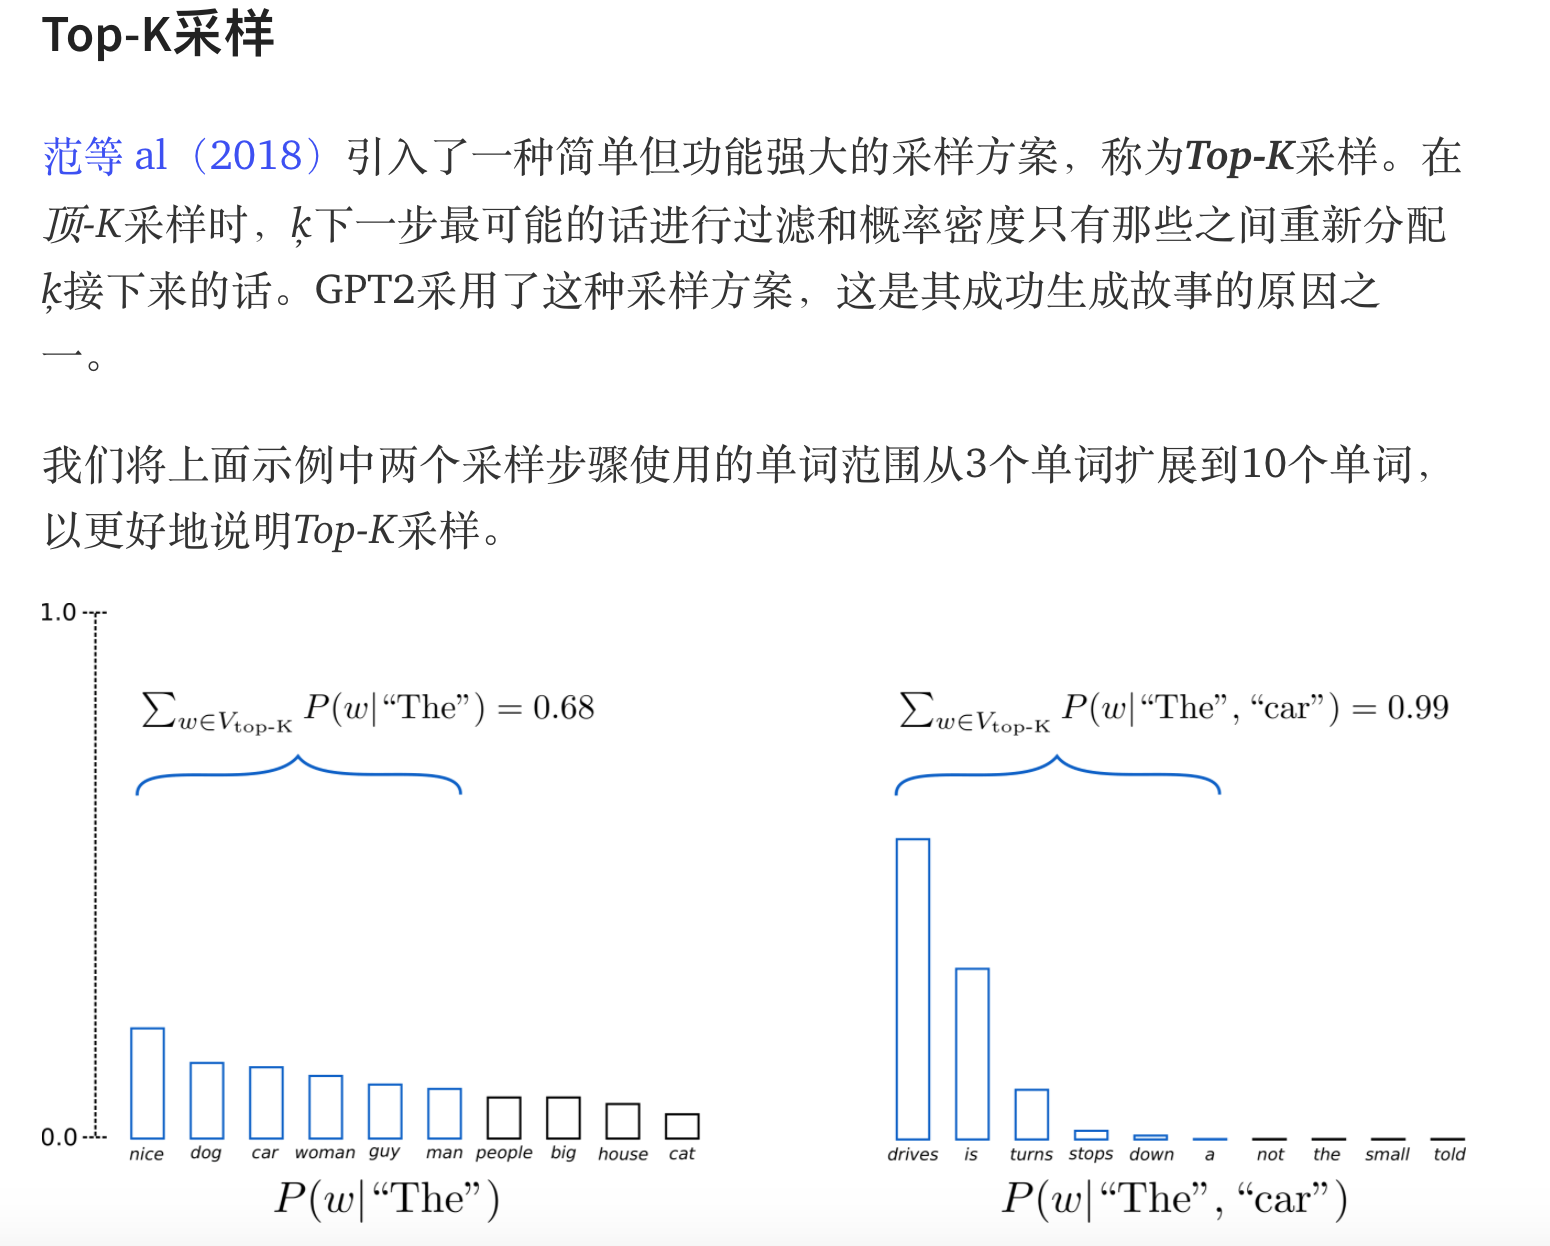

.........

### Top-p（核）采样
在Top-p 采样中，不是从仅最可能的K个单词中采样，而是从其累积概率超过概率p的最小可能单词集中进行选择。然后将概率质量重新分配给这组单词。这样，词集的大小（又名在组词的数量）可以根据下一个单词的概率分布，动态地增加和减少。

In [6]:
# 要获得多个独立采样的输出，我们可以再次 设置参数num_return_sequences > 1：
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog. It's so good to have the chance to walk with a dog. But I have this problem with the dog and how he's always looking at us and always trying to make me see that I can do something
1: I enjoy walking with my cute dog. I like seeing him, I don't like having my dog go through me, but when we walk together that makes for a wonderful bonding moment. I appreciate the interaction, I just don't understand how it would
2: I enjoy walking with my cute dog and playing with our kids," said David J. Smith, director of the Humane Society of the US.

"So as a result, I've got more work in my time," he said.


